<a href="https://colab.research.google.com/github/kurshid1991/Breastcancer_ML-modelling/blob/main/CNN_breakHisv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [3]:
import os
import pandas as pd

# Base directory for your images on Google Drive
base_dir = '/content/drive/MyDrive/images'

# List to hold the data
data = []

# Recursively walk through all folders
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            full_path = os.path.join(root, file).replace('\\', '/')
            parts = full_path.replace(base_dir, '').strip('/').split('/')

            # Extract label and subtype from the folder hierarchy
            label = parts[1] if len(parts) > 1 else 'unknown'  # Magnification (e.g., 100X)
            subtype = parts[2] if len(parts) > 2 else 'unknown'  # Tumor subtype

            # Ensure subtype is one of the valid 8 subtypes
            valid_subtypes = ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']
            if subtype not in valid_subtypes:
                continue  # Skip if the subtype is invalid

            # Append data
            data.append({
                'filepath': full_path,
                'label': label,
                'subtype': subtype
            })

# Convert the data to a DataFrame
df_summary = pd.DataFrame(data)

# Save the summary CSV file
summary_csv_path = '/content/drive/MyDrive/summary_clean.csv'
df_summary.to_csv(summary_csv_path, index=False)

print(f"✅ CSV created with {len(df_summary)} image entries: {summary_csv_path}")
print(df_summary.head())


✅ CSV created with 7914 image entries: /content/drive/MyDrive/summary_clean.csv
                                            filepath      label subtype
0  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
1  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
2  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
3  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
4  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC


In [4]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/content/drive/MyDrive/summary_clean.csv')

# Basic info
print("🔍 Basic Info:")
print(df.info())

# Preview the data
print("\n📋 Head of Data:")
print(df.head())

# Check for missing values
print("\n❗ Missing Values:")
print(df.isnull().sum())


🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7914 entries, 0 to 7913
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  7914 non-null   object
 1   label     7914 non-null   object
 2   subtype   7914 non-null   object
dtypes: object(3)
memory usage: 185.6+ KB
None

📋 Head of Data:
                                            filepath      label subtype
0  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
1  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
2  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
3  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
4  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC

❗ Missing Values:
filepath    0
label       0
subtype     0
dtype: int64


In [5]:
# Count of images by label (e.g., 100X, 200X, 400X)
print("\n🔢 Images by Magnification (label):")
print(df['label'].value_counts())

# Count of images by subtype
print("\n🔢 Images by Subtype:")
print(df['subtype'].value_counts())



🔢 Images by Magnification (label):
label
malignant    5434
benign       2480
Name: count, dtype: int64

🔢 Images by Subtype:
subtype
DC    3451
F     1014
MC     792
LC     626
TA     569
PC     565
PT     453
A      444
Name: count, dtype: int64


In [6]:
# Grouped count
grouped = df.groupby(['label', 'subtype']).size().reset_index(name='count')
print("\n📊 Count by Magnification and Subtype:")
print(grouped)



📊 Count by Magnification and Subtype:
       label subtype  count
0     benign       A    444
1     benign       F   1014
2     benign      PT    453
3     benign      TA    569
4  malignant      DC   3451
5  malignant      LC    626
6  malignant      MC    792
7  malignant      PC    565


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


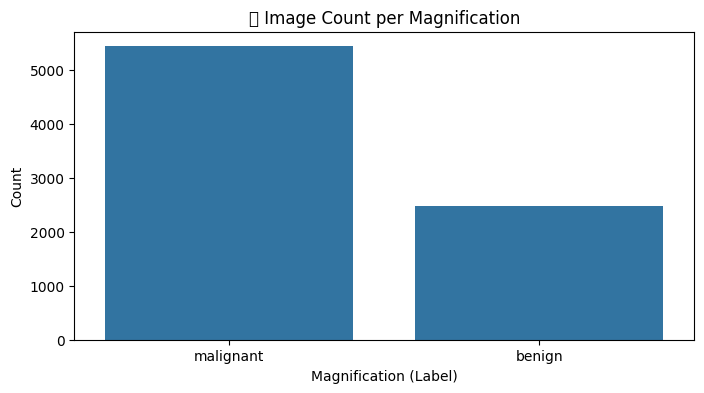

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


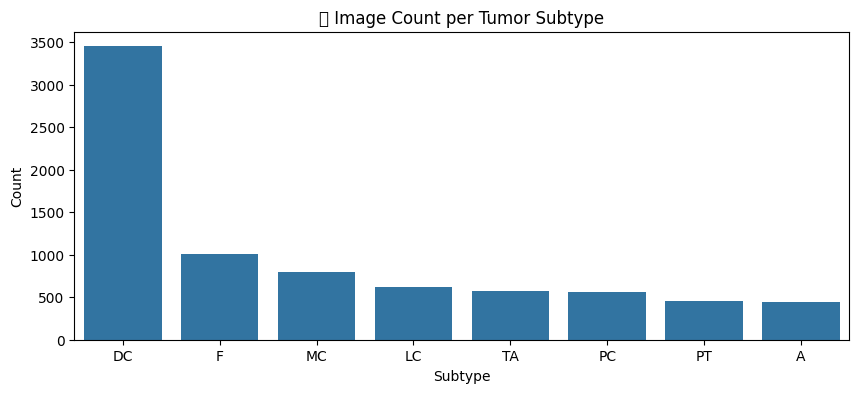

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barplot: Images per magnification (label)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('🧪 Image Count per Magnification')
plt.xlabel('Magnification (Label)')
plt.ylabel('Count')
plt.show()

# Barplot: Images per subtype
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='subtype', order=df['subtype'].value_counts().index)
plt.title('🧬 Image Count per Tumor Subtype')
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.show()



In [ ]:
cd '/content/drive/MyDrive/images'

/content/drive/MyDrive/images


In [8]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# Parameters
base_dir = '/content/drive/MyDrive/images'  # <-- Change if needed
image_size = (224, 224)
max_images_per_subtype = 444
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
valid_subtypes = ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']

print("🚀 Starting image collection...")
print(f"📁 Base directory: {base_dir}")
print(f"✅ Target size: {image_size}")
print(f"🎯 Max images per subtype: {max_images_per_subtype}")
print(f"🔍 Valid subtypes: {valid_subtypes}")
print(f"🖼️ Valid extensions: {valid_extensions}")

# Initialize storage
X = []
y = []
subtype_counter = defaultdict(int)

# Traverse folders
for root, dirs, files in tqdm(os.walk(base_dir), desc="🗂️ Walking through directories"):
    for file in files:
        if file.lower().endswith(valid_extensions):
            filepath = os.path.join(root, file)

            # Extract subtype from folder name
            parts = filepath.replace(base_dir, '').strip('/').split('/')
            subtype = parts[-2] if len(parts) >= 2 else None

            if subtype in valid_subtypes:
                if subtype_counter[subtype] < max_images_per_subtype:
                    try:
                        img = Image.open(filepath).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)

                        X.append(img_array)
                        y.append(subtype)
                        subtype_counter[subtype] += 1

                        if subtype_counter[subtype] % 50 == 0:
                            print(f"✅ Collected {subtype_counter[subtype]} images for subtype: {subtype}")

                    except Exception as e:
                        print(f"❌ Failed to process {filepath}: {e}")

# Final Stats
X = np.array(X)
print("\n📊 Summary:")
print(f"✅ Total images loaded: {X.shape[0]}")
print(f"🖼️ Image shape: {X.shape[1:]}")
print("📈 Images per subtype:")
for k, v in subtype_counter.items():
    print(f"   - {k}: {v}")

# One-hot encode
print("\n🔄 One-hot encoding labels...")
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)
print(f"✅ Labels encoded. Shape: {y_encoded.shape}")
print(f"🏷️ Classes: {lb.classes_}")


🚀 Starting image collection...
📁 Base directory: /content/drive/MyDrive/images
✅ Target size: (224, 224)
🎯 Max images per subtype: 444
🔍 Valid subtypes: ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']
🖼️ Valid extensions: ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')


🗂️ Walking through directories: 0it [00:00, ?it/s]

✅ Collected 50 images for subtype: MC
✅ Collected 100 images for subtype: MC
✅ Collected 150 images for subtype: MC
✅ Collected 200 images for subtype: MC


🗂️ Walking through directories: 4it [00:47, 11.88s/it]

✅ Collected 50 images for subtype: PC
✅ Collected 100 images for subtype: PC


🗂️ Walking through directories: 5it [00:54, 10.55s/it]

✅ Collected 50 images for subtype: LC
✅ Collected 100 images for subtype: LC
✅ Collected 150 images for subtype: LC


🗂️ Walking through directories: 6it [01:16, 13.84s/it]

✅ Collected 50 images for subtype: DC
✅ Collected 100 images for subtype: DC
✅ Collected 150 images for subtype: DC
✅ Collected 200 images for subtype: DC
✅ Collected 250 images for subtype: DC
✅ Collected 300 images for subtype: DC
✅ Collected 350 images for subtype: DC
✅ Collected 400 images for subtype: DC


🗂️ Walking through directories: 7it [01:44, 17.77s/it]

✅ Collected 50 images for subtype: TA
✅ Collected 100 images for subtype: TA


🗂️ Walking through directories: 9it [01:50, 11.14s/it]

✅ Collected 150 images for subtype: TA
✅ Collected 50 images for subtype: PT
✅ Collected 100 images for subtype: PT


🗂️ Walking through directories: 10it [01:55,  9.65s/it]

✅ Collected 50 images for subtype: F
✅ Collected 100 images for subtype: F
✅ Collected 150 images for subtype: F
✅ Collected 200 images for subtype: F


🗂️ Walking through directories: 11it [02:04,  9.59s/it]

✅ Collected 250 images for subtype: F
✅ Collected 50 images for subtype: A
✅ Collected 100 images for subtype: A


🗂️ Walking through directories: 12it [02:10,  8.57s/it]

✅ Collected 150 images for subtype: PC
✅ Collected 200 images for subtype: PC
✅ Collected 250 images for subtype: PC


🗂️ Walking through directories: 15it [02:15,  4.88s/it]

✅ Collected 250 images for subtype: MC
✅ Collected 300 images for subtype: MC
✅ Collected 350 images for subtype: MC


🗂️ Walking through directories: 16it [02:20,  4.96s/it]

✅ Collected 200 images for subtype: LC
✅ Collected 250 images for subtype: LC


🗂️ Walking through directories: 18it [02:27,  4.28s/it]

✅ Collected 300 images for subtype: LC
✅ Collected 150 images for subtype: PT
✅ Collected 200 images for subtype: PT


🗂️ Walking through directories: 20it [02:33,  3.93s/it]

✅ Collected 200 images for subtype: TA
✅ Collected 250 images for subtype: TA


🗂️ Walking through directories: 21it [02:39,  4.22s/it]

✅ Collected 300 images for subtype: F
✅ Collected 350 images for subtype: F
✅ Collected 400 images for subtype: F


🗂️ Walking through directories: 22it [02:47,  5.22s/it]

✅ Collected 150 images for subtype: A
✅ Collected 200 images for subtype: A


🗂️ Walking through directories: 23it [02:53,  5.32s/it]

✅ Collected 350 images for subtype: LC
✅ Collected 400 images for subtype: LC


🗂️ Walking through directories: 27it [02:57,  2.88s/it]

✅ Collected 300 images for subtype: PC
✅ Collected 350 images for subtype: PC
✅ Collected 400 images for subtype: PC


🗂️ Walking through directories: 28it [03:03,  3.41s/it]

✅ Collected 400 images for subtype: MC


🗂️ Walking through directories: 29it [03:08,  3.66s/it]

✅ Collected 250 images for subtype: PT
✅ Collected 300 images for subtype: PT


🗂️ Walking through directories: 32it [03:13,  2.75s/it]

✅ Collected 250 images for subtype: A
✅ Collected 300 images for subtype: A


🗂️ Walking through directories: 33it [03:23,  4.11s/it]

✅ Collected 300 images for subtype: TA
✅ Collected 350 images for subtype: TA
✅ Collected 400 images for subtype: TA


🗂️ Walking through directories: 37it [03:34,  3.08s/it]

✅ Collected 350 images for subtype: PT
✅ Collected 400 images for subtype: PT


🗂️ Walking through directories: 39it [03:39,  2.86s/it]

✅ Collected 350 images for subtype: A
✅ Collected 400 images for subtype: A


🗂️ Walking through directories: 45it [03:51,  5.14s/it]



📊 Summary:
✅ Total images loaded: 3552
🖼️ Image shape: (224, 224, 3)
📈 Images per subtype:
   - MC: 444
   - PC: 444
   - LC: 444
   - DC: 444
   - TA: 444
   - PT: 444
   - F: 444
   - A: 444

🔄 One-hot encoding labels...
✅ Labels encoded. Shape: (3552, 8)
🏷️ Classes: ['A' 'DC' 'F' 'LC' 'MC' 'PC' 'PT' 'TA']


In [17]:
len(X)

3552

In [11]:
print("📊 Unique subtypes collected:", sorted(set(y)))

📊 Unique subtypes collected: ['benign_A', 'benign_F', 'benign_PT', 'benign_TA', 'malignant_DC', 'malignant_LC', 'malignant_MC', 'malignant_PC']


In [10]:
malignant_subtypes = ['DC', 'MC', 'LC', 'PC']
benign_subtypes = ['F', 'TA', 'PT', 'A']

y = [
    f"malignant_{subtype}" if subtype in malignant_subtypes else f"benign_{subtype}"
    for subtype in y
]


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 2486, Validation size: 533, Test size: 533


In [13]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [14]:
labels = ['benign_A', 'benign_F', 'benign_PT', 'benign_TA', 'malignant_DC', 'malignant_LC', 'malignant_MC', 'malignant_PC']
num_classes = len(labels)  # which is 8


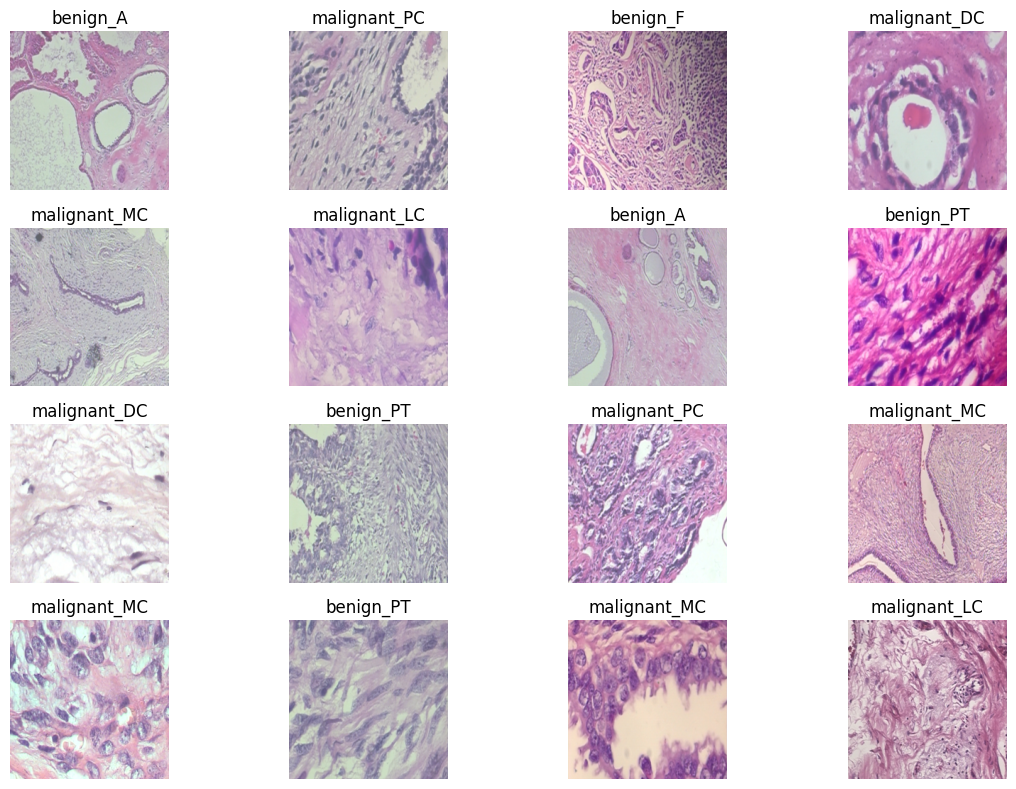

In [18]:
import matplotlib.pyplot as plt
import random

def show_sample_images(X, y, labels, num_images=16):
    plt.figure(figsize=(12, 8))
    indices = random.sample(range(len(X)), num_images)

    for i, idx in enumerate(indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X[idx])
        label_index = y[idx].argmax() if y[idx].ndim > 0 else y[idx]  # works with both one-hot and integer labels
        plt.title(labels[label_index])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
show_sample_images(X_train, y_train, labels)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [22]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # or use num_classes
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,424 (91.20 MB)

 Trainable params: 23,908,424 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

datagen.fit(X_train)


In [25]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.1418 - loss: 3.0867 - val_accuracy: 0.1257 - val_loss: 2.0459
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 370ms/step - accuracy: 0.1550 - loss: 2.0554 - val_accuracy: 0.1782 - val_loss: 2.0498
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.1930 - loss: 2.0303 - val_accuracy: 0.1876 - val_loss: 1.9891
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.1797 - loss: 2.0266 - val_accuracy: 0.1445 - val_loss: 2.0364
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 375ms/step - accuracy: 0.1670 - loss: 2.0442 - val_accuracy: 0.1614 - val_loss: 2.0330
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.1618 - loss: 2.0332 - val_accuracy: 0.1689 - val_loss: 2.0289
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.1672 - loss: 2.0285 - val_accuracy: 0.1745 - val_loss: 2.0304
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 364ms/step - accuracy: 0.1656 - loss: 2.0284 - val_accu